In [1]:
import numpy
%matplotlib nbagg
from matplotlib import pyplot
from tqdm import tqdm, tnrange
from astropy.io import fits

import aotools
from soapy import atmosphere, confParse

In [2]:
def plot_temporal_power_spectrum(x_vals, power_spectra, scale, r0=None, L0=None):
    pyplot.figure()
    pyplot.grid()
    if L0 is not None:
        L0_cutoff = wind_speed/L0
        pyplot.text(L0_cutoff+0.2, 10e8, "V/L0")
        pyplot.plot([L0_cutoff, L0_cutoff], [10, 10e11], linestyle="--",linewidth=1, color="k")


    pyplot.loglog(x_vals, power_spectra.T, alpha=0.2)
    pyplot.loglog(x_vals, power_spectra.mean(0), color="blue")
    pyplot.plot(x_vals, scale * x_vals**(-8./3), color="k", linestyle=":")
    pyplot.xlabel("Frequency (Hz)")
    pyplot.ylabel("Power ($\mathrm{rad}^2$)")

In [3]:
configfile = "../soapy/conf/sh_8x8.yaml"
n_scrns = 1
D = 8.
pupil_size = 128
n_iters = 10000
n_zerns = 50
r0 = 0.20
L0 = 100
wind_speed = 10
time_step = 1./400
noll = fits.getdata("resources/noll.fits").diagonal()[:n_zerns] * (D/r0)**(5./3)
n_tests = 8

In [4]:
config = confParse.loadSoapyConfig(configfile)
scrn_pad = int((config.sim.scrnSize - config.sim.pupilSize)/2)

In [34]:
config.atmos.infinite = True
config.atmos.scrnNo = n_scrns
config.sim.pupilSize = pupil_size
config.atmos.L0 = numpy.array([L0]*n_scrns)
config.atmos.r0 = r0
config.tel.telDiam = D
config.atmos.windSpeeds = numpy.array([wind_speed]*n_scrns)
config.sim.loopTime = time_step


In [38]:
atmos = atmosphere.atmos(config)
print("Number of pixels to translate on each iterations: {}".format(atmos.infinite_phase_screens[0].n_move_pixels))


Number of pixels to translate on each iterations: 0.4


In [7]:
# Create arrary of zernikes
print("Make Zernikes...")
Zs = aotools.zernikeArray(n_zerns, pupil_size)

Make Zernikes...


In [8]:
z_coeffs_inf = numpy.zeros((n_tests, n_iters, n_zerns))
power_spectrum_inf = numpy.zeros((n_tests, n_iters))

for n in tnrange(n_tests):
    atmos = atmosphere.atmos(config)
    screen_buffer = numpy.zeros((n_iters, pupil_size**2))
    for i in tnrange(n_iters):
        scrn = atmos.moveScrns()[0, scrn_pad: -scrn_pad, scrn_pad: -scrn_pad] 
        
        # convert to rad@500nm from nm
        scrn *= 2 * numpy.pi/500
        z_coeffs_inf[n, i] = (scrn * Zs).sum((-1, -2))/(Zs[0].sum())
        screen_buffer[i] = scrn.flatten()

        

    print("Do PS FFT...")
    power_spectra = abs(numpy.fft.fft(screen_buffer, axis=0))**2
    power_spectrum_inf[n] = power_spectra.mean(1)
z_var_inf = z_coeffs_inf.var(1)
power_spectrum_inf = power_spectrum_inf[:, :n_iters//2]

Do PS FFT...


Do PS FFT...


Do PS FFT...


Do PS FFT...


Do PS FFT...


Do PS FFT...


Do PS FFT...


Do PS FFT...



In [13]:
config.atmos.infinite = False
atmos = atmosphere.atmos(config)
z_coeffs_fft = numpy.zeros((n_tests, n_iters, n_zerns))
power_spectrum_fft = numpy.zeros((n_tests, n_iters))

for n in tnrange(n_tests):
    atmos = atmosphere.atmos(config)

    screen_buffer = numpy.zeros((n_iters, pupil_size**2))
    for i in tnrange(n_iters):
        scrn = atmos.moveScrns()[0, scrn_pad: -scrn_pad, scrn_pad: -scrn_pad] 
        
        # convert to rad@500nm from nm
        scrn *= 2 * numpy.pi/500
        
        z_coeffs_fft[n, i] = (scrn * Zs).sum((-1, -2))/(Zs[0].sum())
        screen_buffer[i] = scrn.flatten()

        

    print("Do PS FFT...")
    power_spectra = abs(numpy.fft.fft(screen_buffer, axis=0))**2
    power_spectrum_fft[n] = power_spectra.mean(1)
z_var_fft = z_coeffs_fft.var(1)
power_spectrum_fft = power_spectrum_fft[:, :n_iters//2]

Do PS FFT...


Do PS FFT...


Do PS FFT...


Do PS FFT...


Do PS FFT...


Do PS FFT...


Do PS FFT...


Do PS FFT...



<IPython.core.display.Javascript object>


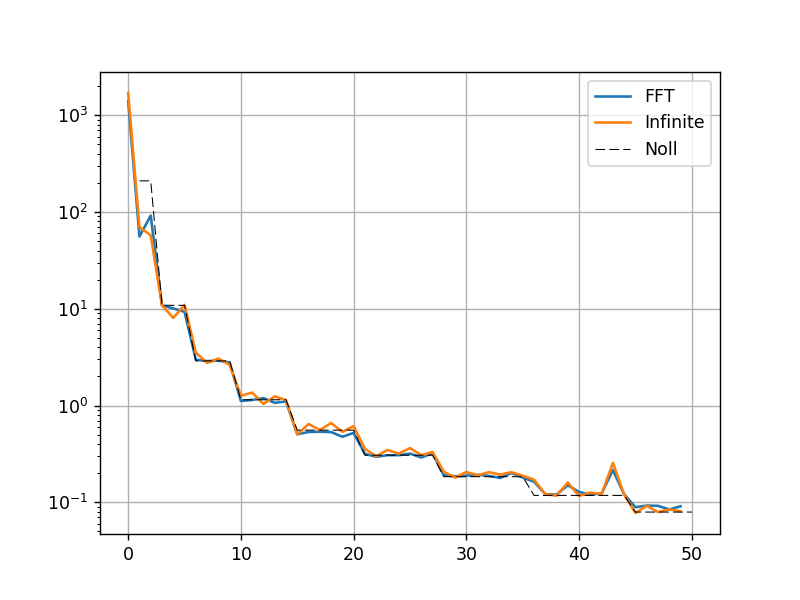

In [23]:
pyplot.figure()
pyplot.semilogy(z_var_fft.mean(0).T, label="FFT")
pyplot.semilogy(z_var_inf.mean(0).T, label="Infinite")
pyplot.grid()
pyplot.semilogy(numpy.arange(1, n_zerns+1), noll, label="Noll", color="k", linestyle="--", linewidth=0.6)
pyplot.legend()

<IPython.core.display.Javascript object>


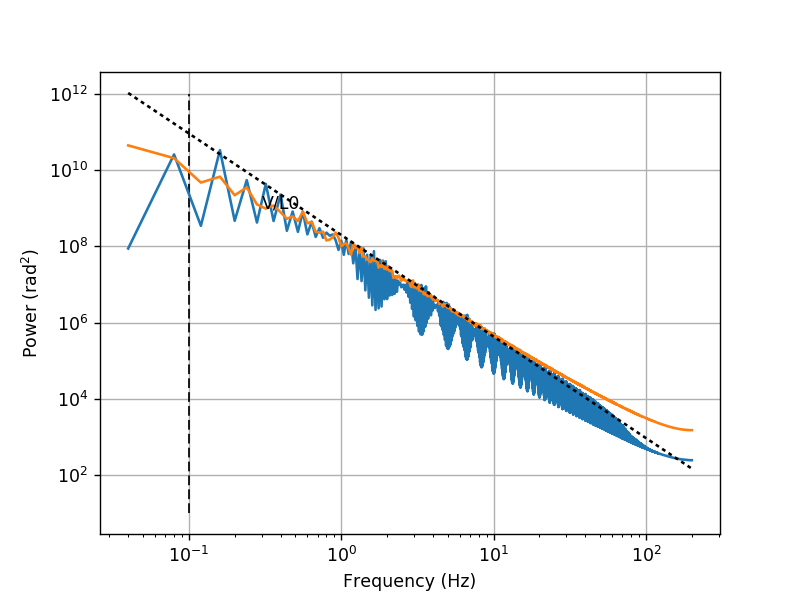

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: RuntimeWarning: divide by zero encountered in power


In [31]:
x_vals = numpy.fft.fftfreq(n_iters, d=time_step)
x_vals = x_vals[:n_iters//2]

power_spectrum_fft = power_spectrum_fft[:, :n_iters//2]
power_spectrum_inf = power_spectrum_inf[:, :n_scrns//2]

pyplot.figure()
pyplot.grid()
L0_cutoff = wind_speed/L0
pyplot.text(L0_cutoff+0.2, 10e8, "V/L0")
pyplot.plot([L0_cutoff, L0_cutoff], [10, 10e11], linestyle="--",linewidth=1, color="k")


pyplot.loglog(x_vals_fft, power_spectrum_fft.mean(0), label="FFT")
pyplot.loglog(x_vals_inf, power_spectrum_inf.mean(0), label="Infinite")
pyplot.plot(x_vals_fft, 2e8 * x_vals_fft**(-8./3), color="k", linestyle=":")
pyplot.xlabel("Frequency (Hz)")
pyplot.ylabel("Power ($\mathrm{rad}^2$)")

In [51]:
config.atmos.L0 = numpy.array([5]*n_scrns)

In [52]:
z_coeffs_inf = numpy.zeros((n_tests, n_iters, n_zerns))
power_spectrum_inf = numpy.zeros((n_tests, n_iters))

for n in tnrange(n_tests):
    atmos = atmosphere.atmos(config)
    screen_buffer = numpy.zeros((n_iters, pupil_size**2))
    for i in tnrange(n_iters):
        scrn = atmos.moveScrns()[0, scrn_pad: -scrn_pad, scrn_pad: -scrn_pad] 
        
        # convert to rad@500nm from nm
        scrn *= 2 * numpy.pi/500
        z_coeffs_inf[n, i] = (scrn * Zs).sum((-1, -2))/(Zs[0].sum())
        screen_buffer[i] = scrn.flatten()

        

    print("Do PS FFT...")
    power_spectra = abs(numpy.fft.fft(screen_buffer, axis=0))**2
    power_spectrum_inf[n] = power_spectra.mean(1)
z_var_inf = z_coeffs_inf.var(1)
power_spectrum_inf = power_spectrum_inf[:, :n_iters//2]

Do PS FFT...


Do PS FFT...


Do PS FFT...


Do PS FFT...


Do PS FFT...


Do PS FFT...


Do PS FFT...


Do PS FFT...



In [53]:
config.atmos.infinite = False
atmos = atmosphere.atmos(config)
z_coeffs_fft = numpy.zeros((n_tests, n_iters, n_zerns))
power_spectrum_fft = numpy.zeros((n_tests, n_iters))

for n in tnrange(n_tests):
    atmos = atmosphere.atmos(config)

    screen_buffer = numpy.zeros((n_iters, pupil_size**2))
    for i in tnrange(n_iters):
        scrn = atmos.moveScrns()[0, scrn_pad: -scrn_pad, scrn_pad: -scrn_pad] 
        
        # convert to rad@500nm from nm
        scrn *= 2 * numpy.pi/500
        
        z_coeffs_fft[n, i] = (scrn * Zs).sum((-1, -2))/(Zs[0].sum())
        screen_buffer[i] = scrn.flatten()

        

    print("Do PS FFT...")
    power_spectra = abs(numpy.fft.fft(screen_buffer, axis=0))**2
    power_spectrum_fft[n] = power_spectra.mean(1)
z_var_fft = z_coeffs_fft.var(1)
power_spectrum_fft = power_spectrum_fft[:, :n_iters//2]


Do PS FFT...


Do PS FFT...


Do PS FFT...


Do PS FFT...


Do PS FFT...


Do PS FFT...


Do PS FFT...


Do PS FFT...



<IPython.core.display.Javascript object>


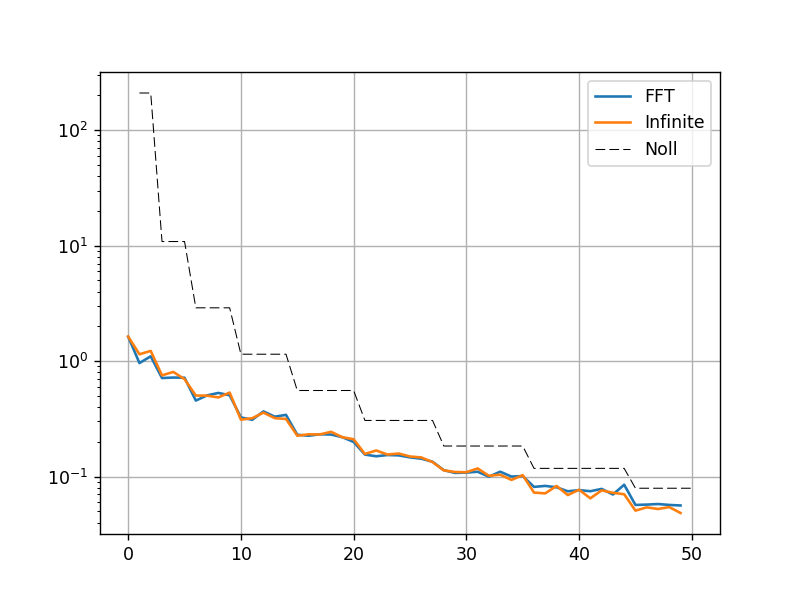

In [54]:
pyplot.figure()
pyplot.semilogy(z_var_fft.mean(0).T, label="FFT")
pyplot.semilogy(z_var_inf.mean(0).T, label="Infinite")
pyplot.grid()
pyplot.semilogy(numpy.arange(1, n_zerns+1), noll, label="Noll", color="k", linestyle="--", linewidth=0.6)
pyplot.legend()

<IPython.core.display.Javascript object>


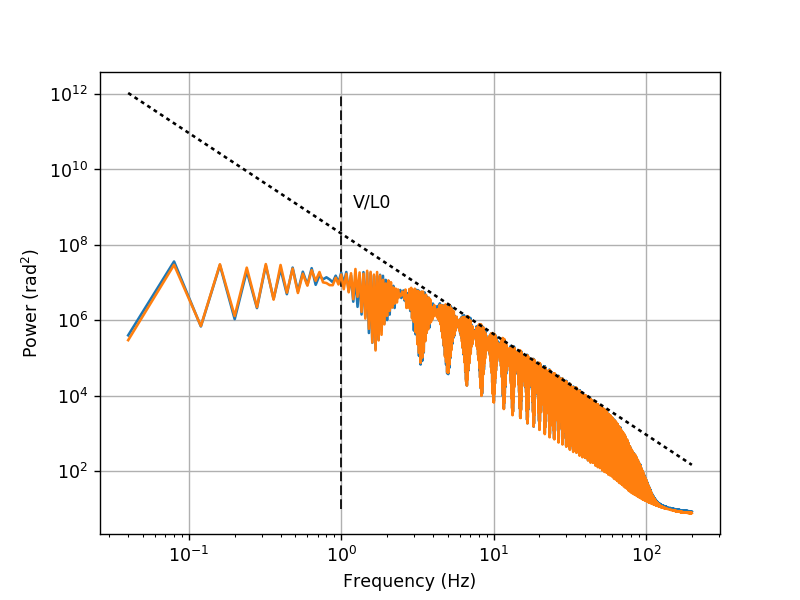

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2903: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  'left=%s, right=%s') % (left, right))
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: RuntimeWarning: divide by zero encountered in power


In [55]:
x_vals = numpy.fft.fftfreq(n_iters, d=time_step)
x_vals = x_vals[:n_iters//2]

pyplot.figure()
pyplot.grid()
L0_cutoff = wind_speed/L0
pyplot.text(L0_cutoff+0.2, 10e8, "V/L0")
pyplot.plot([L0_cutoff, L0_cutoff], [10, 10e11], linestyle="--",linewidth=1, color="k")


pyplot.loglog(x_vals, power_spectrum_fft.mean(0), label="FFT")
pyplot.loglog(x_vals, power_spectrum_inf.mean(0), label="Infinite")
pyplot.plot(x_vals_fft, 2e8 * x_vals**(-8./3), color="k", linestyle=":")
pyplot.xlabel("Frequency (Hz)")
pyplot.ylabel("Power ($\mathrm{rad}^2$)")